In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport optimization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os.path
from datetime import datetime
import numpy as np
from scipy import linalg
from pylab import *
from matplotlib.backends.backend_pdf import PdfPages
import h5py
from sklearn.decomposition.factor_analysis import FactorAnalysis

from optimization import *
import simulation

In [20]:
np.random.seed(0)

T = 200
l = 1e-4
std = 1
p = 0
L = 2
N = 20

high = np.log(25 / T)
low = np.log(5 / T)

# simulate latent processes
# x, ticks = simulation.latents(L, T, std, l)
x = np.empty((T, L), dtype=float)
x[:T // 2, 0] = high
x[T // 2:, 0] = low
x[:, 1] = 2 * np.sin(np.linspace(0, 2 * np.pi * 5, T))
for l in range(L):
    x[:, l] -= np.mean(x[:, l])

# simulate spike trains
# a = np.empty((L, N), dtype=float)
a = 2 * np.random.rand(L, N) - 1
for l in range(L):
    a[l, :] /= linalg.norm(a[l, :]) / np.sqrt(N)

b = np.empty((1 + p, N))
# b[0, :] = np.diag(np.dot(a.T, (a < 0) * -(high + low)))
b[0, :] = low
y, _, rate = simulation.spikes(x, a, b, intercept=True)

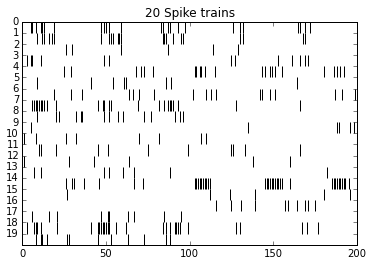

In [21]:
figure()
ylim(0, N)
for n in range(N):
    vlines(np.arange(T)[y[:, n] > 0], n, n + 1, color='black')
title('{} Spike trains'.format(N))
yticks(range(N))
gca().invert_yaxis()

In [22]:
fa = FactorAnalysis(n_components=L)
m0 = fa.fit_transform(y)
a0 = fa.components_
# a0 = np.random.randn(L, N)
m0 *= np.linalg.norm(a0) / np.sqrt(N)
a0 /= np.linalg.norm(a0) / np.sqrt(N)

mu = np.zeros_like(x)

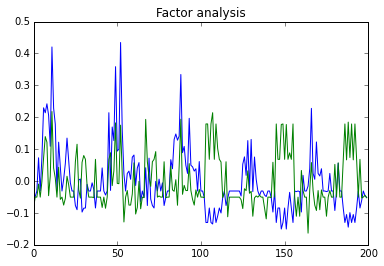

In [23]:
figure()
plot(m0)
title('Factor analysis')

In [26]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-3
w[1] = 1e-3

control = {'max iteration': 100,
           'fixed-point iteration': 3,
           'tol': 1e-4,
           'verbose': True}

lbound, m1, V1, a1, b1, new_var, new_scale, a0, b0, elapsed, converged = variational(y, 0, mu, var, w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               V0=None,
                                                               guardV=False, guardSigma=False,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=True,
                                                               control=control)


Iteration[1]
lower bound = -4331.05433
increment = 47940240.0186622888
change in alpha = 0.0000000000
change in beta = 0.9999991380
change in posterior mean = 0.3471409823
change in posterior covariance = 4.9999996274
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
posterior covariance[0] caused decrease
posterior covariance[1] caused decrease
lower bound = -1260.77187
increment = 3070.2824635028
change in alpha = 1.5350265968
change in beta = 1.3846763759
change in posterior mean = 0.8204907246
change in posterior covariance = 0.0760120173
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
posterior covariance[0] caused decrease
posterior covariance[1] caused decrease
lower bound = -1153.87620
increment = 106.8956639827
change in alpha = 0.8333629100
change in beta = 1.5644808907
change in posterior mean = 0.5685564944
change in posterior covariance = 0.0736225562
change in prior variance = 0.000000000

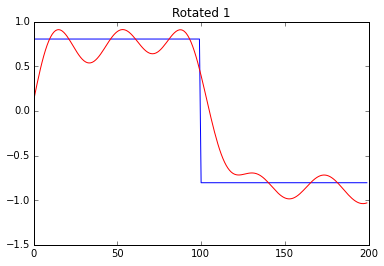

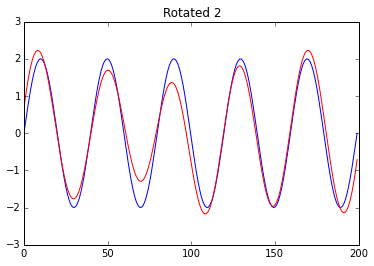

In [29]:
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [28]:
i, j = np.meshgrid(np.arange(T), np.arange(T))
logcor = -(i - j) ** 2
logcor

array([[     0,     -1,     -4, ..., -38809, -39204, -39601],
       [    -1,      0,     -1, ..., -38416, -38809, -39204],
       [    -4,     -1,      0, ..., -38025, -38416, -38809],
       ..., 
       [-38809, -38416, -38025, ...,      0,     -1,     -4],
       [-39204, -38809, -38416, ...,     -1,      0,     -1],
       [-39601, -39204, -38809, ...,     -4,     -1,      0]])

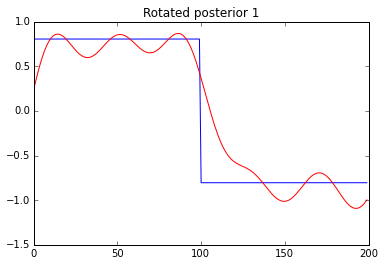

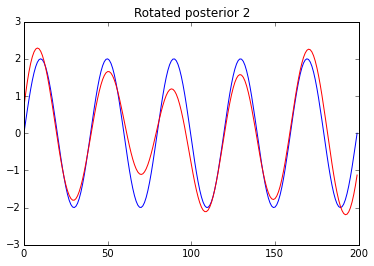

In [33]:
c = linalg.lstsq(m, x)[0]
m2 = np.dot(m, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(m2[:, l], label='transformed posterior', color='red')
    title('Rotated posterior {}'.format(l + 1))

In [116]:
ngrid = 5
v = np.logspace(-0.5, 0.3, num=ngrid, base=0.1)
grid = np.squeeze(np.dstack((np.repeat(v, ngrid), np.tile(v, ngrid))))
grid

array([[ 3.16227766,  3.16227766],
       [ 3.16227766,  1.99526231],
       [ 3.16227766,  1.25892541],
       [ 3.16227766,  0.79432823],
       [ 3.16227766,  0.50118723],
       [ 1.99526231,  3.16227766],
       [ 1.99526231,  1.99526231],
       [ 1.99526231,  1.25892541],
       [ 1.99526231,  0.79432823],
       [ 1.99526231,  0.50118723],
       [ 1.25892541,  3.16227766],
       [ 1.25892541,  1.99526231],
       [ 1.25892541,  1.25892541],
       [ 1.25892541,  0.79432823],
       [ 1.25892541,  0.50118723],
       [ 0.79432823,  3.16227766],
       [ 0.79432823,  1.99526231],
       [ 0.79432823,  1.25892541],
       [ 0.79432823,  0.79432823],
       [ 0.79432823,  0.50118723],
       [ 0.50118723,  3.16227766],
       [ 0.50118723,  1.99526231],
       [ 0.50118723,  1.25892541],
       [ 0.50118723,  0.79432823],
       [ 0.50118723,  0.50118723]])

In [117]:
lb4v = np.empty(ngrid ** 2)
for i in range(ngrid ** 2):
    lbound, m, V, a1, b1, a0, b0, elapsed, converged = variational(y, 0, mu, grid[i, :], w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=False,
                                                               control=control)
    lb4v[i] = lbound[-1]


Iteration[2]:
lower bound = -1839.37933
increment = 199710008587.6876525879
change in alpha = 0.0000000000
change in beta = 0.9999260286
change in posterior mean = 0.4011826867
change in posterior covariance = 3.1622521205

Iteration[3]:
lower bound = -910.79827
increment = 928.5810563000
change in alpha = 1.5607923406
change in beta = 1.3846847292
change in posterior mean = 0.8780724005
change in posterior covariance = 0.0799305180

Iteration[4]:
lower bound = -870.72811
increment = 40.0701680219
change in alpha = 1.0188854941
change in beta = 1.5679662955
change in posterior mean = 2.1711224717
change in posterior covariance = 0.0402451821

Iteration[5]:
lower bound = -821.48477
increment = 49.2433359615
change in alpha = 0.9578346310
change in beta = 2.6414923632
change in posterior mean = 1.1317515791
change in posterior covariance = 0.0828169020

Iteration[6]:
lower bound = -796.69636
increment = 24.7884124453
change in alpha = 0.7348937072
change in beta = 0.6532300987
change in

In [166]:
z = np.column_stack((grid, lb4v))
z

array([[  3.16227766e+00,   3.16227766e+00,  -7.77609290e+02],
       [  3.16227766e+00,   1.99526231e+00,  -7.90410577e+02],
       [  3.16227766e+00,   1.25892541e+00,  -7.95076581e+02],
       [  3.16227766e+00,   7.94328235e-01,  -7.96503446e+02],
       [  3.16227766e+00,   5.01187234e-01,   2.52380668e+11],
       [  1.99526231e+00,   3.16227766e+00,  -7.90109337e+02],
       [  1.99526231e+00,   1.99526231e+00,  -7.96985344e+02],
       [  1.99526231e+00,   1.25892541e+00,  -8.05772217e+02],
       [  1.99526231e+00,   7.94328235e-01,  -8.11476398e+02],
       [  1.99526231e+00,   5.01187234e-01,   2.52380668e+11],
       [  1.25892541e+00,   3.16227766e+00,  -7.99015943e+02],
       [  1.25892541e+00,   1.99526231e+00,  -8.07985772e+02],
       [  1.25892541e+00,   1.25892541e+00,  -8.18528539e+02],
       [  1.25892541e+00,   7.94328235e-01,  -8.19519911e+02],
       [  1.25892541e+00,   5.01187234e-01,  -8.24189160e+02],
       [  7.94328235e-01,   3.16227766e+00,  -7.9744605

In [167]:
mz = z[np.ma.masked_less(lb4v, 0).mask, :]
mz

array([[  3.16227766e+00,   3.16227766e+00,  -7.77609290e+02],
       [  3.16227766e+00,   1.99526231e+00,  -7.90410577e+02],
       [  3.16227766e+00,   1.25892541e+00,  -7.95076581e+02],
       [  3.16227766e+00,   7.94328235e-01,  -7.96503446e+02],
       [  1.99526231e+00,   3.16227766e+00,  -7.90109337e+02],
       [  1.99526231e+00,   1.99526231e+00,  -7.96985344e+02],
       [  1.99526231e+00,   1.25892541e+00,  -8.05772217e+02],
       [  1.99526231e+00,   7.94328235e-01,  -8.11476398e+02],
       [  1.25892541e+00,   3.16227766e+00,  -7.99015943e+02],
       [  1.25892541e+00,   1.99526231e+00,  -8.07985772e+02],
       [  1.25892541e+00,   1.25892541e+00,  -8.18528539e+02],
       [  1.25892541e+00,   7.94328235e-01,  -8.19519911e+02],
       [  1.25892541e+00,   5.01187234e-01,  -8.24189160e+02],
       [  7.94328235e-01,   3.16227766e+00,  -7.97446058e+02],
       [  7.94328235e-01,   1.99526231e+00,  -8.11828533e+02],
       [  7.94328235e-01,   1.25892541e+00,  -8.1917040

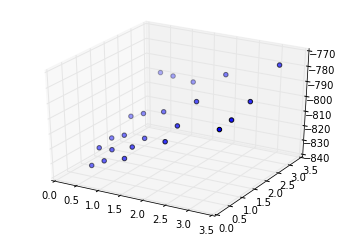

In [229]:
from mpl_toolkits.mplot3d import Axes3D
fig = figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mz[:, 0], mz[:, 1], mz[:, 2])

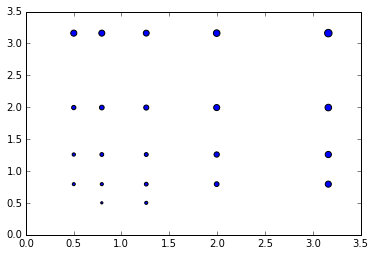

In [169]:
figure()
scatter(mz[:,0], mz[:, 1], s=mz[:, 2] - np.min(mz[:, 2]))

In [170]:
control = {'max iteration': 20,
           'fixed-point iteration': 3,
           'tol': 1e-4,
           'verbose': True}
ngrid = 5
v2 = np.linspace(3, 10, num=ngrid)
grid2 = np.squeeze(np.dstack((np.repeat(v2, ngrid), np.tile(v2, ngrid))))
grid2

array([[  3.  ,   3.  ],
       [  3.  ,   4.75],
       [  3.  ,   6.5 ],
       [  3.  ,   8.25],
       [  3.  ,  10.  ],
       [  4.75,   3.  ],
       [  4.75,   4.75],
       [  4.75,   6.5 ],
       [  4.75,   8.25],
       [  4.75,  10.  ],
       [  6.5 ,   3.  ],
       [  6.5 ,   4.75],
       [  6.5 ,   6.5 ],
       [  6.5 ,   8.25],
       [  6.5 ,  10.  ],
       [  8.25,   3.  ],
       [  8.25,   4.75],
       [  8.25,   6.5 ],
       [  8.25,   8.25],
       [  8.25,  10.  ],
       [ 10.  ,   3.  ],
       [ 10.  ,   4.75],
       [ 10.  ,   6.5 ],
       [ 10.  ,   8.25],
       [ 10.  ,  10.  ]])

In [171]:
lb4v2 = np.empty(ngrid ** 2)
for i in range(ngrid ** 2):
    lbound, m, V, a1, b1, a0, b0, elapsed, converged = variational(y, 0, mu, grid2[i, :], w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=False,
                                                               control=control)
    lb4v2[i] = lbound[-1]


Iteration[2]:
lower bound = -1841.16511
increment = 142419536247.3195495605
change in alpha = 0.0000000000
change in beta = 0.9998904018
change in posterior mean = 0.4060230103
change in posterior covariance = 2.9999635357

Iteration[3]:
lower bound = -965.61119
increment = 875.5539167704
change in alpha = 1.5625715176
change in beta = 1.3846854864
change in posterior mean = 1.3232165508
change in posterior covariance = 0.1058573015

Iteration[4]:
lower bound = -928.78185
increment = 36.8293446798
change in alpha = 1.3468145872
change in beta = 1.5825004841
change in posterior mean = 2.6482892166
change in posterior covariance = 0.1201678635

Iteration[5]:
lower bound = -887.47411
increment = 41.3077383414
change in alpha = 1.0360305228
change in beta = 2.8662783487
change in posterior mean = 1.1504598810
change in posterior covariance = 0.0892630909

Iteration[6]:
lower bound = -868.40331
increment = 19.0708002736
change in alpha = 0.8489084869
change in beta = 0.9685228019
change in

In [173]:
z2 = np.column_stack((grid2, lb4v2))
z2

array([[  3.00000000e+00,   3.00000000e+00,  -7.98632829e+02],
       [  3.00000000e+00,   4.75000000e+00,  -7.84216832e+02],
       [  3.00000000e+00,   6.50000000e+00,  -7.78057097e+02],
       [  3.00000000e+00,   8.25000000e+00,  -7.74928400e+02],
       [  3.00000000e+00,   1.00000000e+01,  -7.73534806e+02],
       [  4.75000000e+00,   3.00000000e+00,   2.08946002e+10],
       [  4.75000000e+00,   4.75000000e+00,   2.08946002e+10],
       [  4.75000000e+00,   6.50000000e+00,   2.08946002e+10],
       [  4.75000000e+00,   8.25000000e+00,   3.37903798e+10],
       [  4.75000000e+00,   1.00000000e+01,   2.08946002e+10],
       [  6.50000000e+00,   3.00000000e+00,  -7.82066840e+02],
       [  6.50000000e+00,   4.75000000e+00,  -7.77041826e+02],
       [  6.50000000e+00,   6.50000000e+00,  -7.68129981e+02],
       [  6.50000000e+00,   8.25000000e+00,  -7.81882833e+02],
       [  6.50000000e+00,   1.00000000e+01,  -7.68340375e+02],
       [  8.25000000e+00,   3.00000000e+00,   7.9394744

In [174]:
mz2 = z2[np.ma.masked_less(lb4v2, 0).mask, :]
mz2

array([[   3.        ,    3.        , -798.63282874],
       [   3.        ,    4.75      , -784.21683199],
       [   3.        ,    6.5       , -778.05709686],
       [   3.        ,    8.25      , -774.92840013],
       [   3.        ,   10.        , -773.53480563],
       [   6.5       ,    3.        , -782.06683989],
       [   6.5       ,    4.75      , -777.04182562],
       [   6.5       ,    6.5       , -768.12998113],
       [   6.5       ,    8.25      , -781.88283271],
       [   6.5       ,   10.        , -768.34037472],
       [   8.25      ,   10.        , -768.05198823],
       [  10.        ,    3.        , -776.81534385],
       [  10.        ,    4.75      , -772.60661644],
       [  10.        ,    6.5       , -767.53247394],
       [  10.        ,    8.25      , -769.49644665],
       [  10.        ,   10.        , -773.56095274]])

In [187]:
mz_stack = np.vstack((mz, mz2))
mz_sorted = mz_stack[np.argsort(mz_stack[:, 2]), :]
mz_sorted

array([[  5.01187234e-01,   5.01187234e-01,  -8.33709371e+02],
       [  7.94328235e-01,   5.01187234e-01,  -8.28680285e+02],
       [  5.01187234e-01,   7.94328235e-01,  -8.24702899e+02],
       [  7.94328235e-01,   7.94328235e-01,  -8.24209073e+02],
       [  1.25892541e+00,   5.01187234e-01,  -8.24189160e+02],
       [  5.01187234e-01,   1.25892541e+00,  -8.22849309e+02],
       [  1.25892541e+00,   7.94328235e-01,  -8.19519911e+02],
       [  7.94328235e-01,   1.25892541e+00,  -8.19170400e+02],
       [  1.25892541e+00,   1.25892541e+00,  -8.18528539e+02],
       [  5.01187234e-01,   1.99526231e+00,  -8.15413803e+02],
       [  7.94328235e-01,   1.99526231e+00,  -8.11828533e+02],
       [  1.99526231e+00,   7.94328235e-01,  -8.11476398e+02],
       [  1.25892541e+00,   1.99526231e+00,  -8.07985772e+02],
       [  1.99526231e+00,   1.25892541e+00,  -8.05772217e+02],
       [  1.25892541e+00,   3.16227766e+00,  -7.99015943e+02],
       [  3.00000000e+00,   3.00000000e+00,  -7.9863282

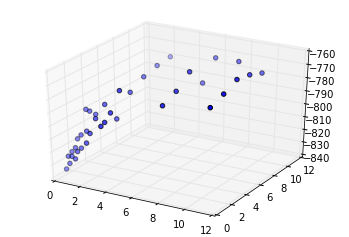

In [230]:
fig = figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mz_sorted[:, 0], mz_sorted[:, 1], mz_sorted[:, 2])

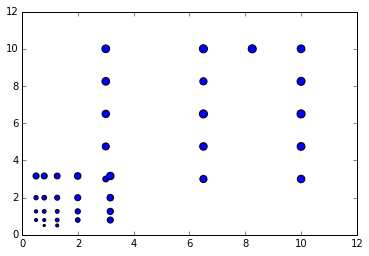

In [190]:
figure()
scatter(mz_sorted[:, 0], mz_sorted[:, 1], s=mz_sorted[:, 2] - np.min(mz_sorted[:, 2]))

In [196]:
control = {'max iteration': 20,
           'fixed-point iteration': 3,
           'tol': 1e-3,
           'verbose': False}
ngrid = 5
v3 = np.linspace(10, 13, num=ngrid)
grid3 = np.squeeze(np.dstack((np.repeat(v3, ngrid), np.tile(v3, ngrid))))
grid3

array([[ 10.  ,  10.  ],
       [ 10.  ,  10.75],
       [ 10.  ,  11.5 ],
       [ 10.  ,  12.25],
       [ 10.  ,  13.  ],
       [ 10.75,  10.  ],
       [ 10.75,  10.75],
       [ 10.75,  11.5 ],
       [ 10.75,  12.25],
       [ 10.75,  13.  ],
       [ 11.5 ,  10.  ],
       [ 11.5 ,  10.75],
       [ 11.5 ,  11.5 ],
       [ 11.5 ,  12.25],
       [ 11.5 ,  13.  ],
       [ 12.25,  10.  ],
       [ 12.25,  10.75],
       [ 12.25,  11.5 ],
       [ 12.25,  12.25],
       [ 12.25,  13.  ],
       [ 13.  ,  10.  ],
       [ 13.  ,  10.75],
       [ 13.  ,  11.5 ],
       [ 13.  ,  12.25],
       [ 13.  ,  13.  ]])

In [197]:
lb4v3 = np.empty(ngrid ** 2)
for i in range(ngrid ** 2):
    lbound, m, V, a1, b1, a0, b0, elapsed, converged = variational(y, 0, mu, grid3[i, :], w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=False,
                                                               control=control)
    lb4v3[i] = lbound[-1]

LinAlgError: 133-th leading minor not positive definite

In [198]:
lb4v3

array([ -7.73560953e+02,  -7.63901854e+02,  -7.66486721e+02,
        -7.63848785e+02,  -7.94493282e+02,  -7.63678211e+02,
        -7.61403733e+02,  -7.59597132e+02,  -7.57869275e+02,
        -7.60544750e+02,  -7.69111099e+02,  -7.61901907e+02,
        -7.62484260e+02,  -7.68033066e+02,  -7.65547664e+02,
         2.71632432e+08,  -7.88112263e+02,   1.63039767e+10,
         1.63039767e+10,   1.22500000e+01,   1.30000000e+01,
         1.30000000e+01,   1.30000000e+01,   1.30000000e+01,
         1.30000000e+01])

In [224]:
mz_all = np.vstack((mz_stack, np.column_stack((grid3, lb4v3))[np.ma.masked_less(lb4v3, 0).mask, :]))
np.set_printoptions(precision=4)
mz_all[np.argsort(mz_all[:, 2]), :]

array([[  5.0119e-01,   5.0119e-01,  -8.3371e+02],
       [  7.9433e-01,   5.0119e-01,  -8.2868e+02],
       [  5.0119e-01,   7.9433e-01,  -8.2470e+02],
       [  7.9433e-01,   7.9433e-01,  -8.2421e+02],
       [  1.2589e+00,   5.0119e-01,  -8.2419e+02],
       [  5.0119e-01,   1.2589e+00,  -8.2285e+02],
       [  1.2589e+00,   7.9433e-01,  -8.1952e+02],
       [  7.9433e-01,   1.2589e+00,  -8.1917e+02],
       [  1.2589e+00,   1.2589e+00,  -8.1853e+02],
       [  5.0119e-01,   1.9953e+00,  -8.1541e+02],
       [  7.9433e-01,   1.9953e+00,  -8.1183e+02],
       [  1.9953e+00,   7.9433e-01,  -8.1148e+02],
       [  1.2589e+00,   1.9953e+00,  -8.0799e+02],
       [  1.9953e+00,   1.2589e+00,  -8.0577e+02],
       [  1.2589e+00,   3.1623e+00,  -7.9902e+02],
       [  3.0000e+00,   3.0000e+00,  -7.9863e+02],
       [  7.9433e-01,   3.1623e+00,  -7.9745e+02],
       [  1.9953e+00,   1.9953e+00,  -7.9699e+02],
       [  5.0119e-01,   3.1623e+00,  -7.9666e+02],
       [  3.1623e+00,   7.9433e

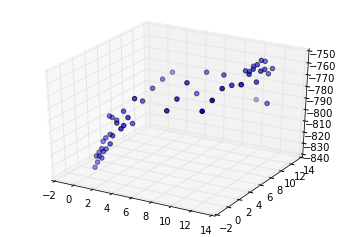

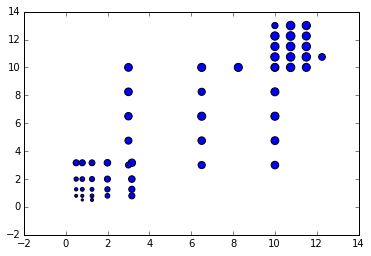

In [228]:
fig = figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mz_all[:, 0], mz_all[:, 1], mz_all[:, 2])
figure()
scatter(mz_all[:, 0], mz_all[:, 1], s=mz_all[:, 2] - np.min(mz_all[:, 2]))

In [212]:
var = np.empty(L, dtype=float)
var[0] = 11
var[1] = 12
w = np.empty(L, dtype=float)
w[0] = 1e-3
w[1] = 1e-3

initial = {'alpha': a0,
           'beta': None,
           'posterior mean': mu}

control = {'max iteration': 50,
           'fixed-point iteration': 3,
           'tol': 1e-4,
           'verbose': True}

lbound, m, V, a1, b1, a0, b0, elapsed, converged = variational(y, 0, mu, var, w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=False,
                                                               control=control)


Iteration[2]:
lower bound = -12830747763.28744
increment = 361827847556251.6875000000
change in alpha = 0.0000000000
change in beta = 1.0000000000
change in posterior mean = 1.0081142632
change in posterior covariance = 11.9999999980

Iteration[3]:
lower bound = -3207687366.35854
increment = 9623060396.9288997650
change in alpha = 1.2529935201
change in beta = 1.3846456701
change in posterior mean = 1.9034017414
change in posterior covariance = 0.0892909009

Iteration[4]:
lower bound = -673421137.24286
increment = 2534266229.1156797409
change in alpha = 1.4464564782
change in beta = 1.5650434218
change in posterior mean = 1.7656748157
change in posterior covariance = 0.0805197548

Iteration[5]:
lower bound = -160324339.18583
increment = 513096798.0570302010
change in alpha = 0.9518182330
change in beta = 0.0000000000
change in posterior mean = 0.7632876923
change in posterior covariance = 0.0797197504

Iteration[6]:
lower bound = -39454159.60568
increment = 120870179.5801434517
change

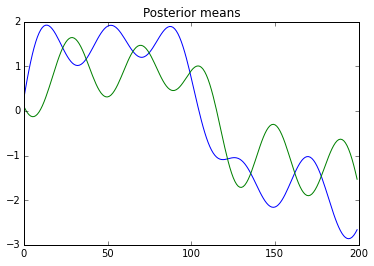

In [213]:
figure()
plot(m)
title('Posterior means')

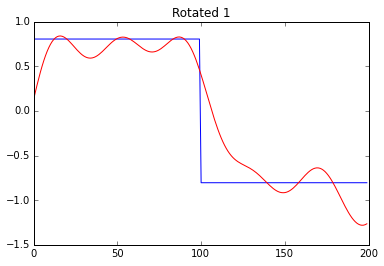

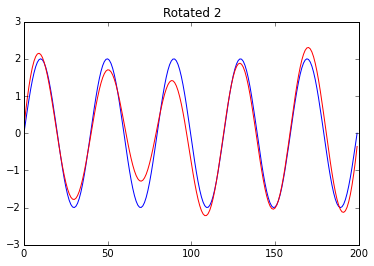

In [214]:
c = linalg.lstsq(m, x)[0]
m2 = np.dot(m, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(m2[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))


Iteration[2]:
lower bound = -12830747763.28744
increment = 361827847556251.6875000000
change in alpha = 0.0000000000
change in beta = 1.0000000000
change in posterior mean = 1.0081142632
change in posterior covariance = 11.9999999980

Iteration[3]:
lower bound = -3207687366.35854
increment = 9623060396.9288997650
change in alpha = 1.2529935201
change in beta = 1.3846456701
change in posterior mean = 1.9034017414
change in posterior covariance = 0.0892909009

Iteration[4]:
lower bound = -673421137.24286
increment = 2534266229.1156797409
change in alpha = 1.4464564782
change in beta = 1.5650434218
change in posterior mean = 1.7656748157
change in posterior covariance = 0.0805197548

Iteration[5]:
lower bound = -160324339.18583
increment = 513096798.0570302010
change in alpha = 0.9518182330
change in beta = 0.0000000000
change in posterior mean = 0.7632876923
change in posterior covariance = 0.0797197504
d.T * d 218.317677508
S inv d -627012645.61
S inv V 213.129615922
d.T * d 89.0473636

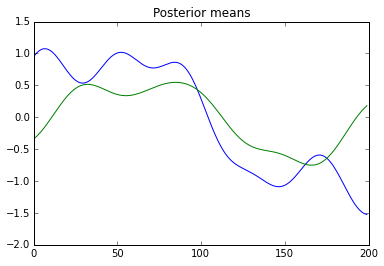

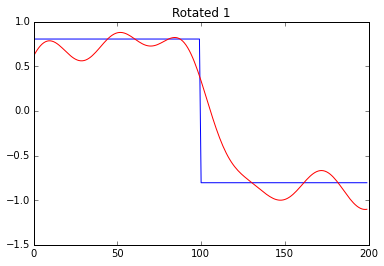

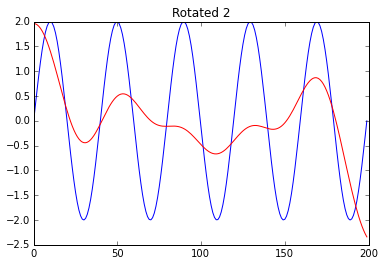

In [215]:
var = np.empty(L, dtype=float)
var[0] = 11
var[1] = 12
w = np.empty(L, dtype=float)
w[0] = 1e-3
w[1] = 1e-3

initial = {'alpha': a0,
           'beta': None,
           'posterior mean': mu}

control = {'max iteration': 50,
           'fixed-point iteration': 3,
           'tol': 1e-4,
           'verbose': True}

lbound, m, V, a1, b1, a0, b0, elapsed, converged = variational(y, 0, mu, var, w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=True,
                                                               control=control)

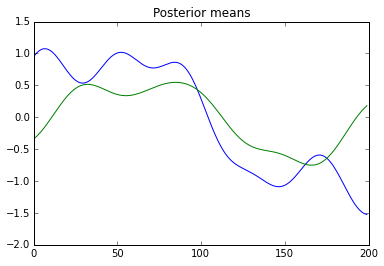

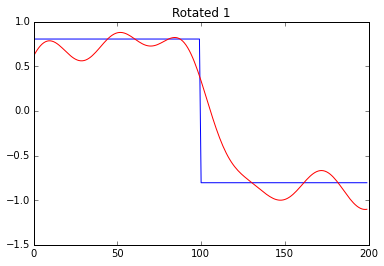

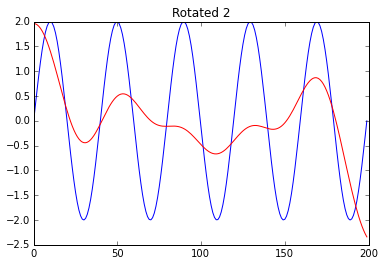

In [216]:
figure()
plot(m)
title('Posterior means')

c = linalg.lstsq(m, x)[0]
m2 = np.dot(m, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(m2[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [218]:
control = {'max iteration': 100,
           'fixed-point iteration': 3,
           'tol': 1e-5,
           'verbose': True}

lbound, m, V, a1, b1, a0, b0, elapsed, converged = variational(y, 0, mu, var, w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=True,
                                                               control=control)


Iteration[2]:
lower bound = -12830747763.28744
increment = 361827847556251.6875000000
change in alpha = 0.0000000000
change in beta = 1.0000000000
change in posterior mean = 1.0081142632
change in posterior covariance = 11.9999999980

Iteration[3]:
lower bound = -3207687366.35854
increment = 9623060396.9288997650
change in alpha = 1.2529935201
change in beta = 1.3846456701
change in posterior mean = 1.9034017414
change in posterior covariance = 0.0892909009

Iteration[4]:
lower bound = -673421137.24286
increment = 2534266229.1156797409
change in alpha = 1.4464564782
change in beta = 1.5650434218
change in posterior mean = 1.7656748157
change in posterior covariance = 0.0805197548

Iteration[5]:
lower bound = -160324339.18583
increment = 513096798.0570302010
change in alpha = 0.9518182330
change in beta = 0.0000000000
change in posterior mean = 0.7632876923
change in posterior covariance = 0.0797197504
d.T * d 218.317677508
S inv d -627012645.61
S inv V 213.129615922
d.T * d 89.0473636

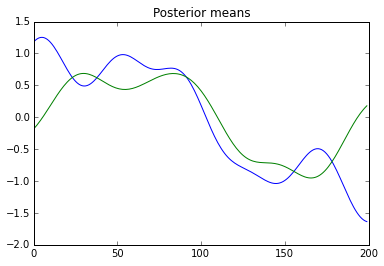

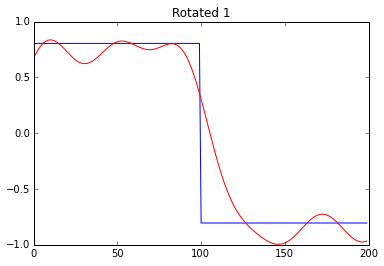

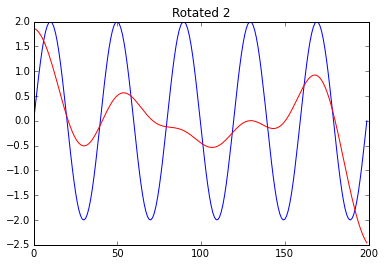

In [219]:
figure()
plot(m)
title('Posterior means')

c = linalg.lstsq(m, x)[0]
m2 = np.dot(m, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(m2[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [288]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-3
w[1] = 1e-3

control = {'max iteration': 50,
           'fixed-point iteration': 3,
           'tol': 1e-3,
           'verbose': True}

lbound, m1, V1, a1, b1, new_var, new_scale, a0, b0, elapsed, converged = variational(y, 0, mu, var, w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               V0=None,
                                                               guardV=True,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=False,
                                                               control=control)


Iteration[1]
lower bound = -6116.79977
increment = 46021111390.9085388184
change in alpha = 0.1663508652
change in beta = 0.9999990142
change in posterior mean = 0.3017490262
change in posterior covariance = 4.9999998340
change in prior variance = 0.0000000000

Iteration[2]
lower bound = -922.78818
increment = 5194.0115909239
change in alpha = 3.8003655204
change in beta = 1.3836493125
change in posterior mean = 0.7235288899
change in posterior covariance = 0.1113333231
change in prior variance = 0.0000000000

Iteration[3]
lower bound = -861.64165
increment = 61.1465312999
change in alpha = 1.0254920817
change in beta = 1.5625304178
change in posterior mean = 2.3775061754
change in posterior covariance = 0.2248440171
change in prior variance = 0.0000000000

Iteration[4]
lower bound = -840.43615
increment = 21.2054972161
change in alpha = 0.9858494097
change in beta = 0.0000000000
change in posterior mean = 1.3694812269
change in posterior covariance = 0.1037428644
change in prior vari

IndexError: index 50 is out of bounds for axis 0 with size 50

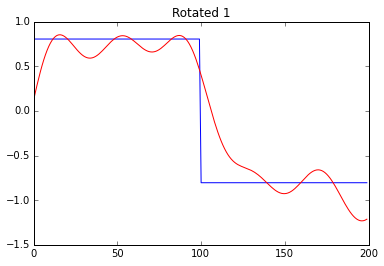

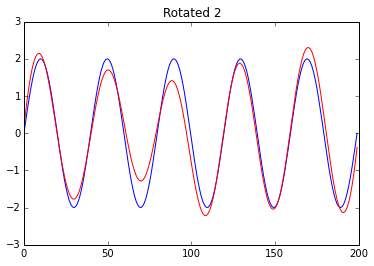

In [277]:
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [278]:
lbound, m2, V2, a2, b2, new_var, new_scale, a0, b0, elapsed, converged = variational(y, 0, mu, var, w,
                                                               a0=a1,
                                                               b0=b1,
                                                               m0=m1,
                                                               V0=V1,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=True,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=True,
                                                               control=control)


Iteration[2]:
lower bound = -751.57549
increment = 0.0122323183
change in alpha = 0.0120587312
change in beta = 0.0090021368
change in posterior mean = 0.0134766609
change in posterior covariance = 0.0000000000
change in prior variance = 0.0000000000

Iteration[3]:
lower bound = -751.56801
increment = 0.0074737674
change in alpha = 0.0000000000
change in beta = 0.0308614821
change in posterior mean = 0.0127724552
change in posterior covariance = 0.0000000000
change in prior variance = 0.0000000000

Iteration[4]:
lower bound = -751.56713
increment = 0.0008789351
change in alpha = 0.0129207301
change in beta = 0.0000000000
change in posterior mean = 0.0259923244
change in posterior covariance = 0.0000000000
change in prior variance = 0.0000000000

Iteration[5]:
lower bound = -751.56154
increment = 0.0055950231
change in alpha = 0.0117901970
change in beta = 0.0187595112
change in posterior mean = 0.0000000000
change in posterior covariance = 0.0000000000
change in prior variance = 0.000

In [279]:
new_var

array([ 3.4175,  1.8159])

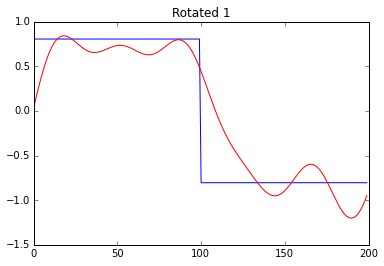

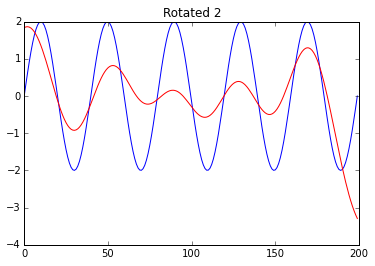

In [280]:
c = linalg.lstsq(m2, x)[0]
rotated = np.dot(m2, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [283]:
new_var

array([ 3.4576,  2.2221])

In [337]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-3
w[1] = 1e-3

control = {'max iteration': 100,
           'fixed-point iteration': 3,
           'tol': 1e-3,
           'verbose': True}

lbound, m1, V1, a1, b1, new_var, new_scale, a0, b0, elapsed, converged = variational(y, 0, mu, var, w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               V0=None,
                                                               guardV=True, guardSigma=True,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=False,
                                                               control=control)


Iteration[1]
lower bound = -2867.16807
increment = 46021114640.5402374268
change in alpha = 0.0000000000
change in beta = 0.9999990142
change in posterior mean = 0.3363939017
change in posterior covariance = 4.9999994894
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -1210.42339
increment = 1656.7446807021
change in alpha = 3.8271705580
change in beta = 1.3836582891
change in posterior mean = 1.0830689312
change in posterior covariance = 0.1357126269
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
posterior covariance[0] caused decrease
lower bound = -1098.58695
increment = 111.8364449258
change in alpha = 1.7521765664
change in beta = 1.5747672624
change in posterior mean = 0.0000000000
change in posterior covariance = 0.1485870153
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -825.86766
increment = 272.7192856088
change in al

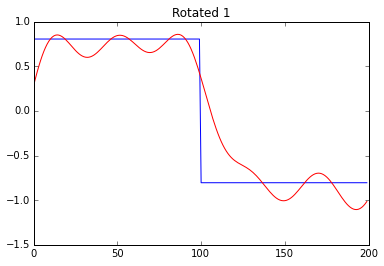

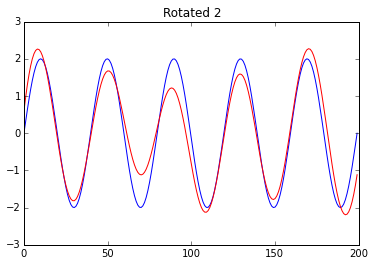

In [338]:
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [417]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-3
w[1] = 1e-3

control = {'max iteration': 100,
           'fixed-point iteration': 3,
           'tol': 1e-3,
           'verbose': True}

lbound, m1, V1, a1, b1, new_var, new_scale, a0, b0, elapsed, converged = variational(y, 0, mu, var, w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               V0=None,
                                                               guardV=False, guardSigma=False,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=True,
                                                               control=control)


Iteration[1]
lower bound = -2878.28609
increment = 46021114653.1873397827
change in alpha = 0.0000000000
change in beta = 0.9999990142
change in posterior mean = 0.3363939017
change in posterior covariance = 4.9999994894
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
posterior covariance[0] caused decrease
posterior covariance[1] caused decrease
lower bound = -1324.47053
increment = 1553.8155555773
change in alpha = 3.8271705580
change in beta = 1.3836582891
change in posterior mean = 1.0830689312
change in posterior covariance = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
posterior covariance[0] caused decrease
posterior covariance[1] caused decrease
lower bound = -1220.60406
increment = 103.8664747758
change in alpha = 2.0757567521
change in beta = 1.5719143107
change in posterior mean = 0.0000000000
change in posterior covariance = 0.0000000000
change in prior variance = 0.000000

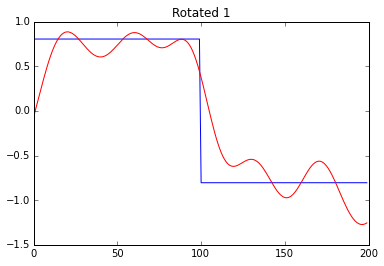

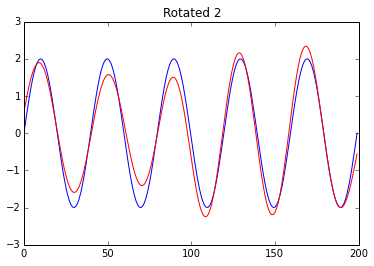

In [482]:
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [517]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-3
w[1] = 1e-3

control = {'max iteration': 100,
           'fixed-point iteration': 3,
           'tol': 1e-4,
           'verbose': True}

lbound, m1, V1, a1, b1, new_var, new_scale, a0, b0, elapsed, converged = variational(y, 0, mu, var, w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               V0=None,
                                                               guardV=False, guardSigma=False,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=True,
                                                               control=control)


Iteration[1]
lower bound = -7500.39990
increment = 37859481.6059117392
change in alpha = 0.1986417074
change in beta = 0.9999990142
change in posterior mean = 0.3103515112
change in posterior covariance = 4.9999998703
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -2741.74139
increment = 4758.6585157812
change in alpha = 4.3297419633
change in beta = 1.0513990989
change in posterior mean = 0.3126037227
change in posterior covariance = 0.1032552852
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -1288.52469
increment = 1453.2166989142
change in alpha = 0.7115737626
change in beta = 0.8049445796
change in posterior mean = 0.3860980993
change in posterior covariance = 0.0649222347
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -1164.11354
increment = 124.4111516983
change in alpha = 0.2688460846
change in beta = 0.577

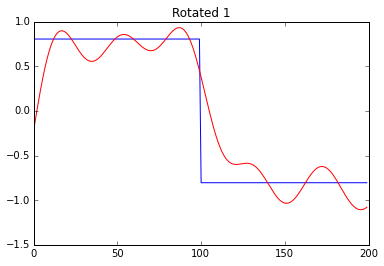

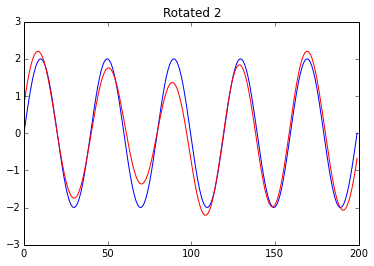

In [518]:
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [519]:
new_var, new_scale

(array([ 9.2846,  4.9988]), array([ 0.0012,  0.001 ]))